In [1]:
import pickle
from pathlib import Path
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

def load_perturbed_graph(graph_name="graph.pkl"):
    """
    Load the perturbed graph from the data directory stored as graph.pkl
    """
    graph_path = Path(graph_name)
    if not graph_path.exists():
        raise FileNotFoundError(f"Graph file not found: {graph_path}. Please run graph perturbation first.")
    
    with open(graph_path, "rb") as f:
        G = pickle.load(f)
    
    return G


def load_gene_mapping():
    """
    Load the gene_to_idx mapping from the shared data directory stored as gene_to_idx.pkl
    This mapping is created by data_creation.py and used by graph_perturbation.py
    """
    # First try experiment-specific path (for backward compatibility)
    mapping_path = Path("gene_to_idx.pkl")
    if mapping_path.exists():
        with open(mapping_path, "rb") as f:
            gene_to_idx = pickle.load(f)
        return gene_to_idx
    
    # Then try shared data path (canonical location)
    shared_mapping_path = "gene_to_idx.pkl"
    if not shared_mapping_path.exists():
        raise FileNotFoundError(f"Gene mapping file not found at {mapping_path} or {shared_mapping_path}. Please run data creation first.")
    
    with open(shared_mapping_path, "rb") as f:
        gene_to_idx = pickle.load(f)
    
    return gene_to_idx

def read_node_values():
    """
    Read the node values from the data directory stored as node_values.pkl
    """
    node_values_path = Path("0.pt")
    if not node_values_path.exists():
        raise FileNotFoundError(f"Node values file not found: {node_values_path}. Please run data creation first.")
    
    # use torch to load the node values
    import torch
    node_values = torch.load(node_values_path, weights_only=False)
    
    return node_values


def plot_graph(graph_name):
    G = load_perturbed_graph(graph_name)
    gene_mapping = load_gene_mapping()
    node_values = read_node_values()
    perturbed_gene = node_values['perturbed_gene']
    difference = node_values['difference']
    # read graph.pkl and print the number of nodes and edges

    # Convert torch_geometric.data.Data to networkx graph
    nx_G = to_networkx(G)

    # Rename nodes in nx_G using mapping (reverse mapping: idx -> gene name)
    reverse_mapping = {v: k for k, v in gene_mapping.items()}
    nx_G = nx.relabel_nodes(nx_G, reverse_mapping)

    print("Number of nodes:", nx_G.number_of_nodes())
    print("Number of edges:", nx_G.number_of_edges())

    # color the nodes in the graph. perturbed_gene in yellow, every other node with 
    # difference != 0 in red, and every other node in blue
    color_map = []
    for node in nx_G:
        if node == perturbed_gene:
            color_map.append('yellow')
        elif difference[gene_mapping[node]] != 0:
            color_map.append('red')
        else:
            color_map.append('blue')
    plt.figure(figsize=(12, 12))
    nx.draw(nx_G, with_labels=True, node_size=100,font_size=8, node_color=color_map)
    plt.show()

Number of nodes: 500
Number of edges: 998


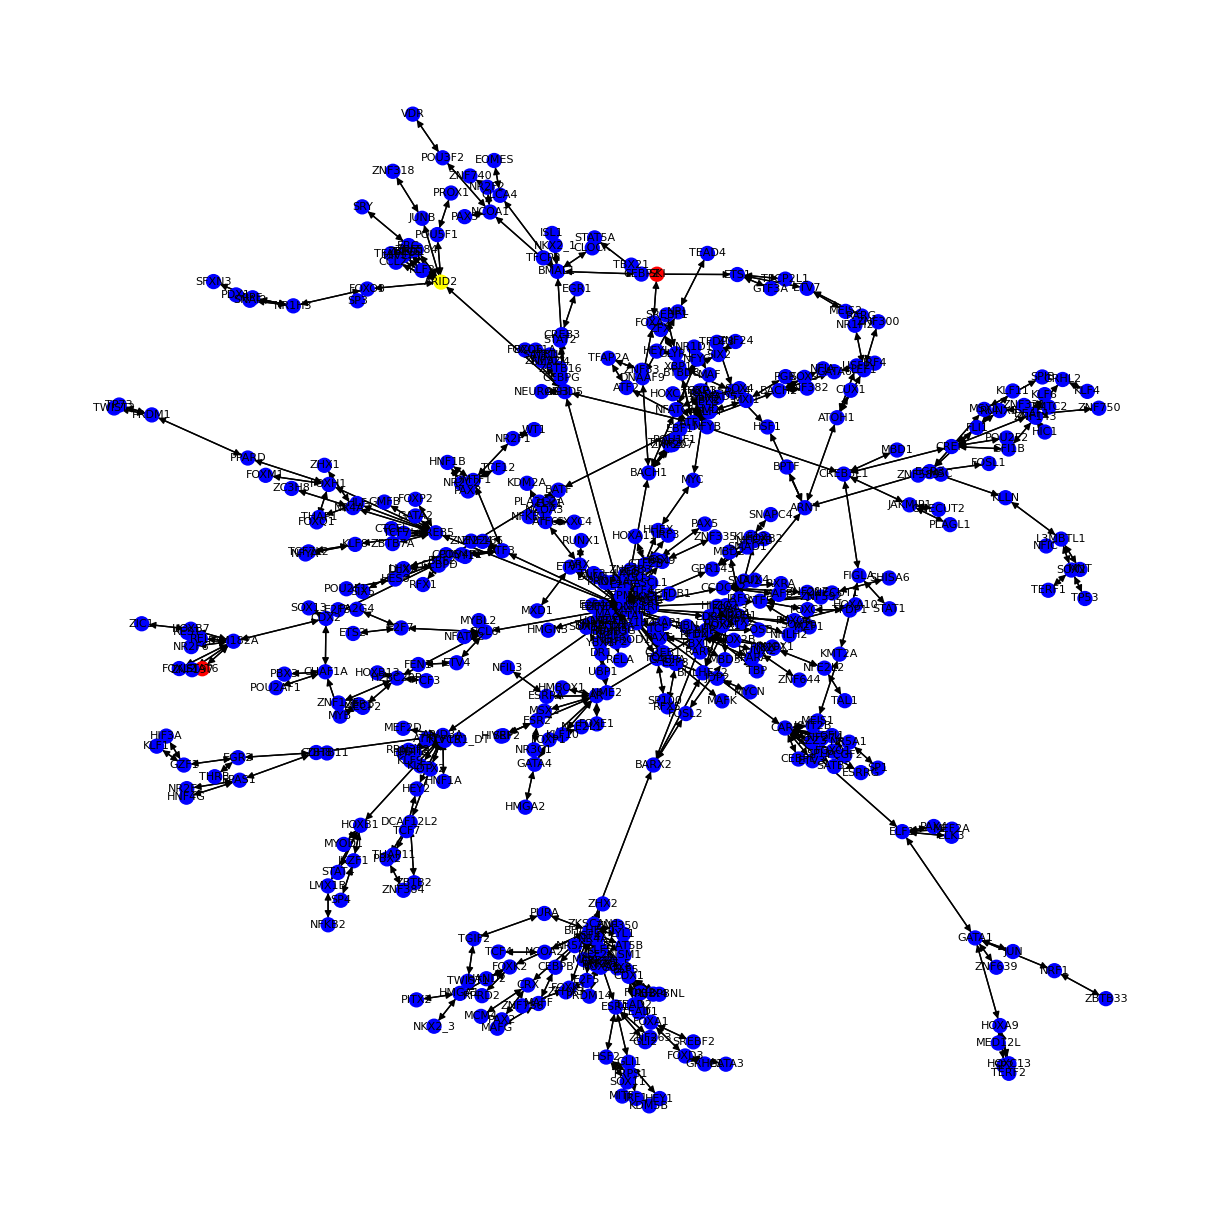

In [2]:
plot_graph("graph.pkl")

Number of nodes: 500
Number of edges: 550


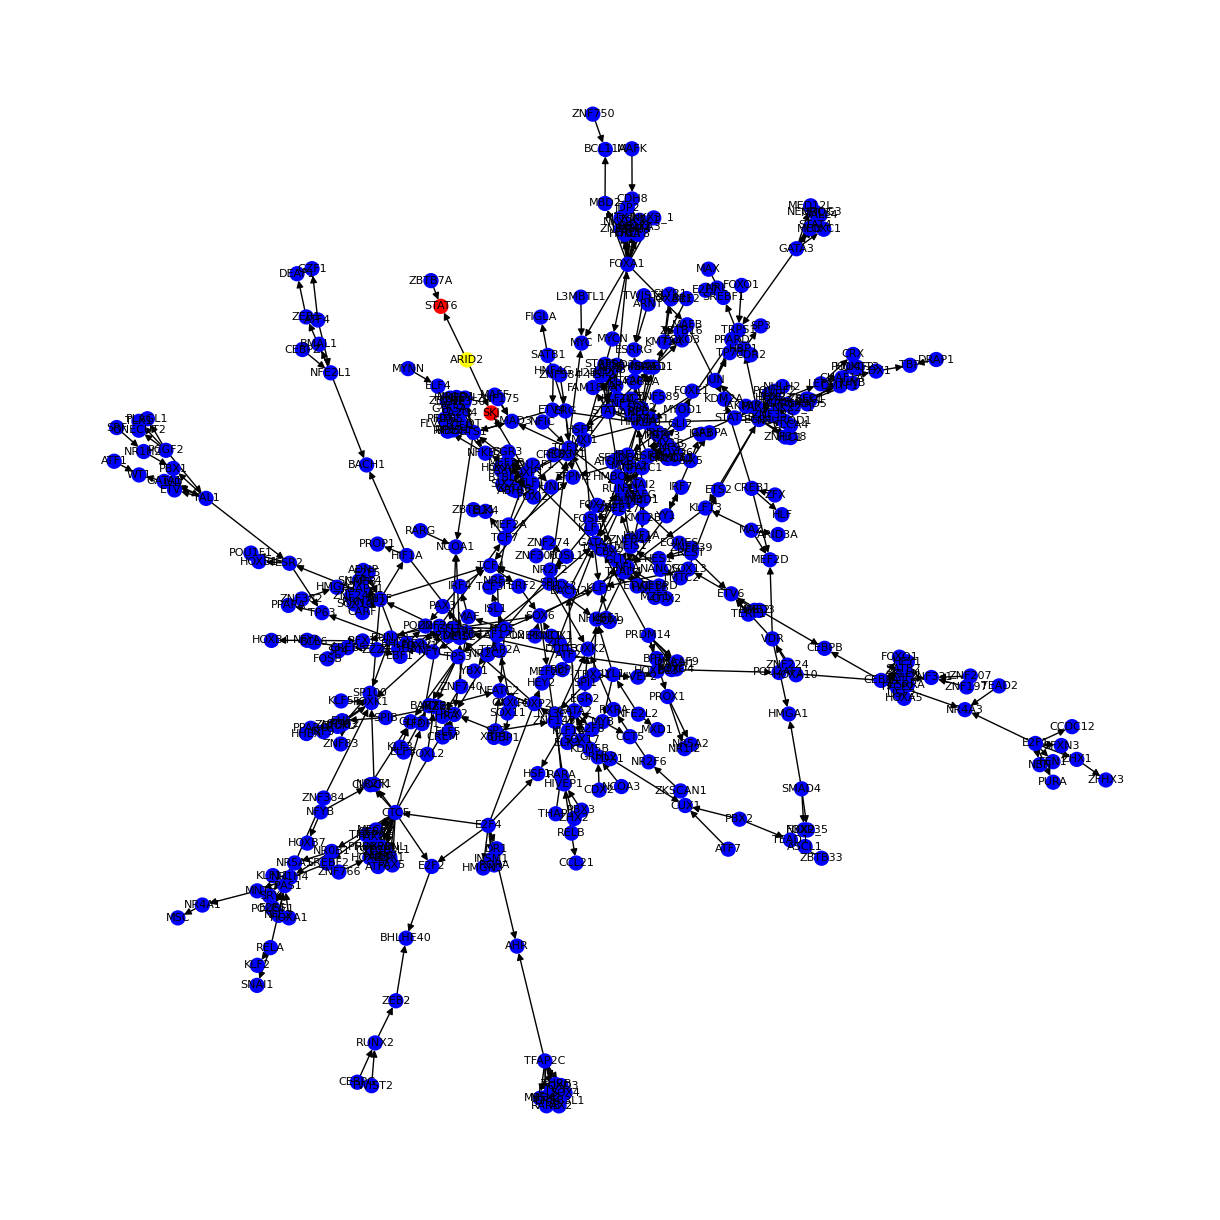

In [3]:
plot_graph("original.pkl")

In [4]:
# Test to verify the fix: check if node ordering is consistent
def verify_node_ordering_fix():
    """
    Verify that the NetworkX graph node ordering matches the gene_to_idx mapping
    """
    import sys
    sys.path.append('/sc/home/johanna.dahlkemper/source_detection_in_grns/src')
    from src import utils
    from pathlib import Path
    from torch_geometric.utils import from_networkx, to_networkx
    
    # Load graph using the fixed utils function
    topo_path = Path('/sc/home/johanna.dahlkemper/source_detection_in_grns/topos/dorothea_500_550.topo')  # Adjust path as needed
    if not topo_path.exists():
        print(f"Topo file not found at {topo_path}")
        print("Available topo files:")
        topo_dir = Path('/sc/home/johanna.dahlkemper/source_detection_in_grns/topos')
        if topo_dir.exists():
            for f in topo_dir.glob('*.topo'):
                print(f"  {f.name}")
        return
    
    G, gene_to_idx = utils.get_graph_data_from_topo(topo_path)
    
    print("Gene to index mapping (first 10):")
    for i, (gene, idx) in enumerate(list(gene_to_idx.items())[:10]):
        print(f"  {gene} -> {idx}")
    
    print(f"\nNetworkX node order (first 10): {list(G.nodes())[:10]}")
    
    # Convert to PyG and back
    pyg_graph = from_networkx(G, group_edge_attrs=['weight'])
    nx_back = to_networkx(pyg_graph)
    
    print(f"PyG conversion - nodes back to NetworkX: {list(nx_back.nodes())[:10]}")
    
    # Verify that the node order matches
    nx_nodes = list(G.nodes())
    sorted_genes = sorted(gene_to_idx.keys())
    
    if nx_nodes == sorted_genes:
        print("\n✅ SUCCESS: NetworkX node order matches sorted gene_to_idx mapping!")
    else:
        print("\n❌ ISSUE: NetworkX node order doesn't match gene_to_idx mapping")
        print(f"Expected (sorted): {sorted_genes[:10]}")
        print(f"Actual (NetworkX): {nx_nodes[:10]}")

verify_node_ordering_fix()

ModuleNotFoundError: No module named 'src'